# Introduction to NoisyCircuits

## Library Imports

In [1]:
from NoisyCircuits import QuantumCircuit as QC
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel

2025-08-22 13:34:24,754	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Setup Input Fields

In the input fields:

1. **token:** refers to the IBM API token for accessing IBM Quantum Systems. See IBM Documentation for account creation and token access [here](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup).
2. **backend_name:** refers to the IBM quantum hardware for which the noise model needs to be built. Currently, the software only supports the IBM Eagle R3 Chip set which have a basis gate set comprising of $X$, $\sqrt{X}$, $R_z(\cdot)$ and $ECR$. As of 15.08.2025, the backend codenamed "ibm_brisbane" is the only available quantum hardware with the Eagle R3 chip.
3. **num_qubits:** the number of qubits in the quantum circuits.
4. **num_cores:** the number of cores to run parallel Monte-Carlo Wavefunction (MCWF) Trajectories. (Ensure sufficient resources are available for runs.)
5. **num_trajectories:** the number of trajectories for the MCWF method.
6. **threshold:** the threshold for filtering out noise data.
7. **jsonize:** a boolean variable indicating whether the noise model needs to be jsonized or if the input noise model is already in a json format.

In [ ]:
token = None # Replace with your IBM Quantum token
backend_name = "ibm_brisbane"
num_qubits = 2
num_cores = 10
num_trajectories = 20
threshold = 1e-4
jsonize = True

### Getting the Noise Model

Run the code below to obtain the noise model from IBM backend calibration data.

In [3]:
noise_model = GetNoiseModel(backend_name=backend_name, token=token).get_noise_model()

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-22 13:35:14,060: Default instance not set. Searching all available instances.


In the case where a valid token cannot be provided, a noise model from IBM Calibration Data (dated: 21.08.2025) is provided as a pickle file that can be imported for use

In [4]:
import pickle

noise_model = pickle.load(open("Noise_Model_from_Hardware.pkl", "rb"))

### Initialize the Circuit Instance

In [4]:
nqc = QC(num_qubits=num_qubits, 
         noise_model=noise_model, 
         num_cores=num_cores, 
         num_trajectories=num_trajectories, 
         threshold=threshold, 
         jsonize=jsonize)

Completed Extraction of ECR Errors.
Starting post-processing on Single Qubit Errors.
Completed post-processing on Single Qubit Errors.
Processing ECR errors.
  Qubit pair (1, 0): 5/9 errors above threshold (4 filtered out)
ECR errors processed.
Building Noise Operators for ECR Errors.
Completed building Noise Operators for ECR Errors.
Extracting Measurement Errors.
Available qubits in roerror_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
Requested qubits: [0, 1]
Completed Extraction of Measurement Errors.
Prep

2025-08-22 13:35:24,549	INFO worker.py:1927 -- Started a local Ray instance.


## Example Circuit

### Example 1: Creating an EPR Pair

First we create an EPR pair generating quantum circuit and execute it as a pure statevector simulation and as a noisy simulation (comparing density matrix and MCWF methods).

In [5]:
# Reset the circuit --> Ensure the circuit tape has no prior instructions
nqc.refresh()

In [6]:
# Create the EPR Pair Circuit
nqc.H(qubit=0)
nqc.CX(control=0, target=1)

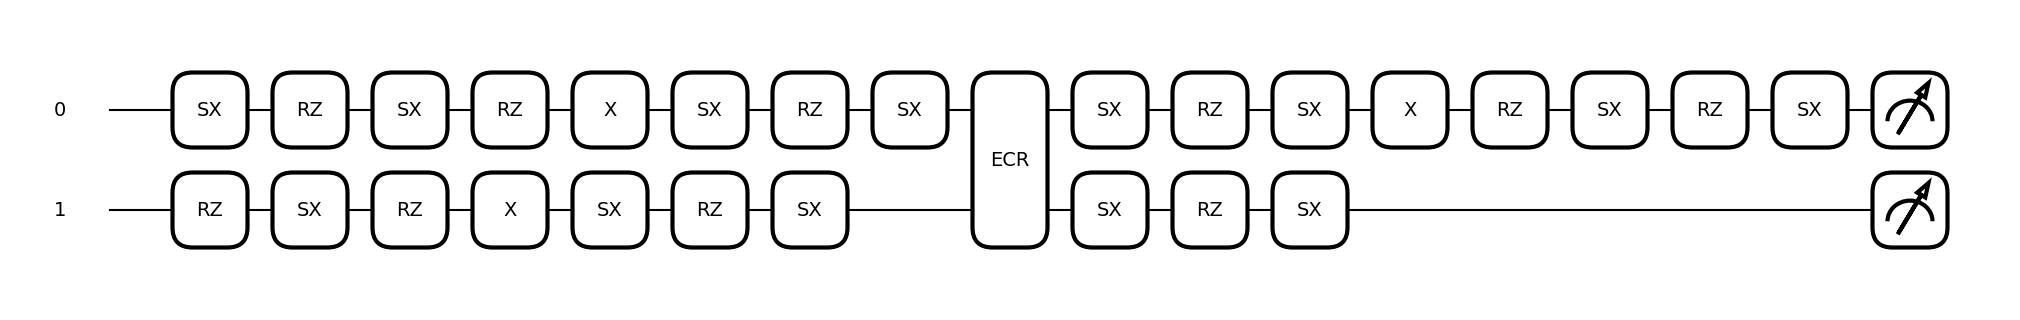

In [7]:
nqc.draw_circuit("mpl")

In [8]:
# Run the circuit with pure state simulation, argument qubits is the measured qubits
nqc.run_pure_state(qubits=[0,1])

array([5.00000000e-01, 3.08148791e-33, 1.54074396e-32, 5.00000000e-01])

In [9]:
# Run the circuit with density matrix simulation
nqc.run_with_density_matrix(qubits=[0,1])

Creating Measurement Error Operator for observable qubits: [0, 1]
Measurement Error Operator created.
Executing the circuit with Density Matrix.


tensor([0.46455586, 0.03555633, 0.03552433, 0.46436348], requires_grad=True)

In [10]:
# Running with MCWF method, here the number of trajectories can be modified from the originally specified value
# The use_prev flag is a boolean that determines whether to use previously initialized measurement errors or not. If an MCWF execution
# has not be run before, then set the flag to False, else leave it with the default value of True.
nqc.execute(qubits=[0,1], num_trajectories=100, use_prev=False)

Creating Measurement Error Operator for observable qubits: [0, 1]
Measurement Error Operator created.
Executing the circuit with 20 trajectories.


tensor([0.46819949, 0.03180051, 0.03180051, 0.46819949], requires_grad=True)

In [11]:
# Here, leaving the use_prev flag as True will use the previously initialized measurement errors.
nqc.execute(qubits=[0,1], num_trajectories=50, use_prev=True)

tensor([0.46819949, 0.03180051, 0.03180051, 0.46819949], requires_grad=True)

For the MCWF method, using more trajectories ensures better convergence to the density matrix result.

### Example 2: Qubit Swap

In this example, we see the effect of noise on a qubit swap between two qubits whose states where initialized using angle encoding.

In [12]:
# nqc.refresh() resets the quantum circuit to zero gates.
# The argument to the rotation gates are the angle, followed by the qubit index.
nqc.refresh()
nqc.RY(theta=1.2, qubit=0)
nqc.RY(theta=0.5, qubit=1)
nqc.SWAP(qubit1=0, qubit2=1)

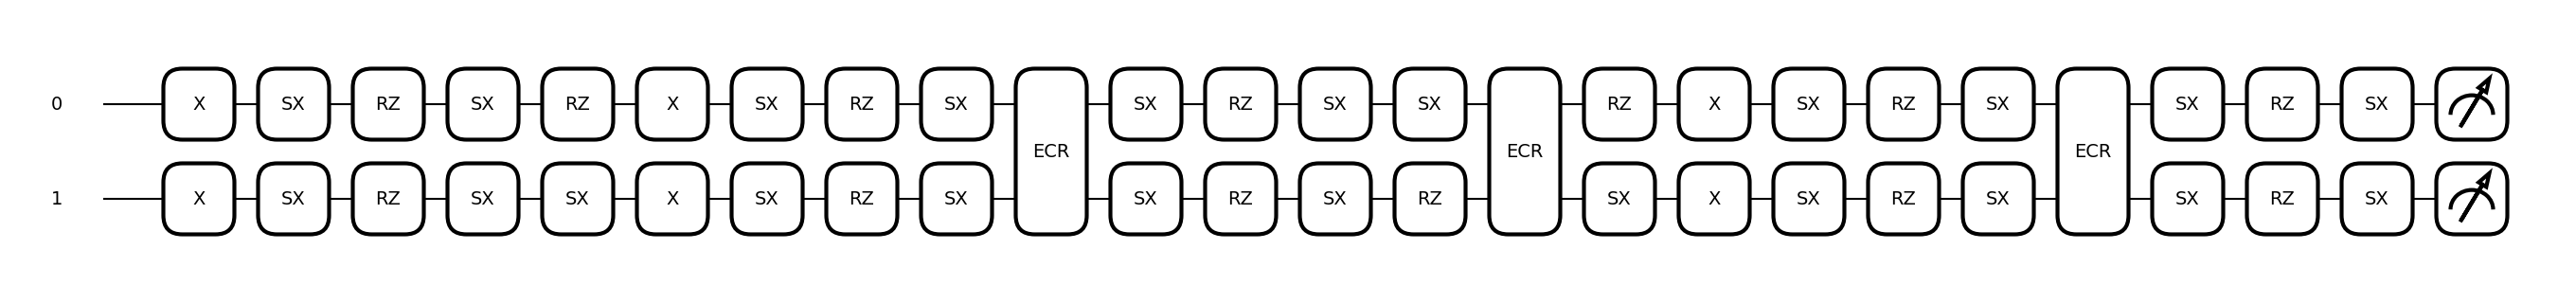

In [13]:
nqc.draw_circuit("mpl")

In [14]:
# Run with pure state simulation
nqc.run_pure_state(qubits=[0,1])

array([0.63948479, 0.29930649, 0.04169409, 0.01951463])

In [15]:
# Run with the density matrix simulation
nqc.run_with_density_matrix(qubits=[0,1])

Creating Measurement Error Operator for observable qubits: [0, 1]
Measurement Error Operator created.
Executing the circuit with Density Matrix.


tensor([0.59849162, 0.29537255, 0.06935923, 0.0367766 ], requires_grad=True)

In [16]:
# Run with MCWF Simulation (keep use_prev to True since the measurement errors are already initialized)
nqc.execute(qubits=[0,1], num_trajectories=100, use_prev=True)

tensor([0.60114979, 0.29910371, 0.065326  , 0.03442051], requires_grad=True)

## Shutdown the Parallel instance

Due to parallel implementation with "ray", there is a requirement to explicitly shutdown the parallel pool

In [17]:
nqc.shutdown()